**# BLOOD CELL CLASSIFICATION**

# Blood Cell Classification using CNN and ResNet50

**Author:** Shivani Boppala  
**Objective:** Multi-class classification of blood cell images using deep learning  



**ABSTRACT**

A Comparetive study of the classification of publicly available Blood cell images using Baslineline CNN , Pretrained models (ResNet 50,  **Vision Transformers**)

**GOAL AND PUPOSE**

Its helps to diagnose medical conditions while detecting infections.

It is useful in Monitoring immune health by automating some parts of the laboratory analysis

**DATASET**

Link :  https://www.kaggle.com/datasets/unclesamulus/blood-cells-image-dataset

Publicky available dataset on Kaggle with over 17K images which are divided into 8 blood cell types.

**RELATED WORK**

Katar, O., & Yildirim, O. (2023). An Explainable Vision Transformer Model Based White Blood Cells Classification and Localization. Diagnostics, 13(14), 2459. https://doi.org/10.3390/diagnostics13142459




In [ ]:
import zipfile, os
import shutil
import math
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import tensorflow.keras.utils

import keras_nlp
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import math
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
DRIVE_ROOT = "/content/drive/MyDrive"
zip_path    = os.path.join(DRIVE_ROOT, "Bloodcells.zip")
folder_path = os.path.join(DRIVE_ROOT, "Bloodcells")
if os.path.exists(zip_path):
    extract_root = "/content/Bloodcells"
    if os.path.exists(extract_root):
        shutil.rmtree(extract_root)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_root)
    data_root = extract_root
elif os.path.exists(folder_path):
    data_root = folder_path

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**DATA EXPLORATION**

In [ ]:
base_dir = 'bloodcells_dataset'
if(os.path.exists(base_dir)):
    shutil.rmtree(base_dir)
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [ ]:
src_data = 'Bloodcells/bloodcells_dataset'
classes = [d for d in os.listdir(src_data) if os.path.isdir(os.path.join(src_data, d))]

#create subdirectories under train/test/val directory directory
for cls in classes:
    os.mkdir(os.path.join(train_dir, cls))
    os.mkdir(os.path.join(validation_dir, cls))
    os.mkdir(os.path.join(test_dir, cls))

In [ ]:
random.seed(42)

for cls in classes:
    src_folder = os.path.join(src_data, cls)
    files = glob.glob(os.path.join(src_folder, '*.jpg'))
    random.shuffle(files)
    n = len(files)
    n_train = int(0.7 * n)
    n_val = int(0.15 * n)

    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]

    for f in train_files:
        shutil.copy(f, os.path.join(train_dir, cls))
    for f in val_files:
        shutil.copy(f, os.path.join(validation_dir, cls))
    for f in test_files:
        shutil.copy(f, os.path.join(test_dir, cls))

#Check to see if the data is copied correctly to the directory structure
for cls in classes:
    print('total training', cls, 'images:', len(os.listdir(os.path.join(train_dir, cls))))
    print('total validation', cls, 'images:', len(os.listdir(os.path.join(validation_dir, cls))))
    print('total test', cls, 'images:', len(os.listdir(os.path.join(test_dir, cls))))
    print()


total training erythroblast images: 1085
total validation erythroblast images: 232
total test erythroblast images: 234

total training neutrophil images: 2330
total validation neutrophil images: 499
total test neutrophil images: 500

total training platelet images: 1643
total validation platelet images: 352
total test platelet images: 353

total training ig images: 2026
total validation ig images: 434
total test ig images: 435

total training eosinophil images: 2181
total validation eosinophil images: 467
total test eosinophil images: 469

total training monocyte images: 993
total validation monocyte images: 213
total test monocyte images: 214

total training lymphocyte images: 849
total validation lymphocyte images: 182
total test lymphocyte images: 183

total training basophil images: 852
total validation basophil images: 182
total test basophil images: 184



In [ ]:
# Class Balances
class_counts = []
for cls in classes:
    train_count = len(os.listdir(os.path.join(train_dir, cls)))
    val_count = len(os.listdir(os.path.join(validation_dir, cls)))
    test_count = len(os.listdir(os.path.join(test_dir, cls)))
    total_count = train_count + val_count + test_count
    class_counts.append({"Class": cls, "Total Images": total_count})

df = pd.DataFrame(class_counts)
display(df)

Class  Total Images
0  erythroblast          1551
1    neutrophil          3329
2      platelet          2348
3            ig          2895
4    eosinophil          3117
5      monocyte          1420
6    lymphocyte          1214
7      basophil          1218

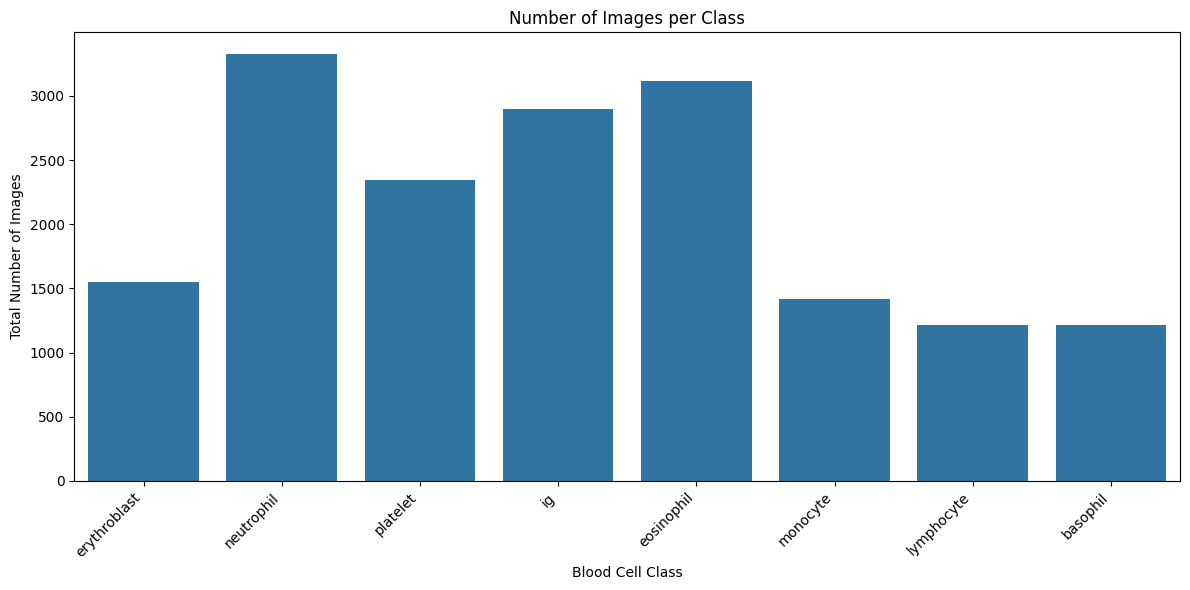

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Total Images', data=df)
plt.title('Number of Images per Class')
plt.xlabel('Blood Cell Class')
plt.ylabel('Total Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Checking the size of the image
from PIL import Image

img = Image.open("/content/bloodcells_dataset/test/monocyte/MO_113269.jpg")
width, height = img.size

print("Width:", width)
print("Height:", height)


Width: 360
Height: 363


**DATA PREPARATION**


In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(224 , 224),
    batch_size=32,
    shuffle=True,
    label_mode='categorical'
)

validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,  # prevent random mixing each epoch
    label_mode='categorical'
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    label_mode='categorical'
)

# Performance improvement: Prefetch GPU pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(AUTOTUNE)
validation_dataset = validation_dataset.prefetch(AUTOTUNE)


Found 11959 files belonging to 8 classes.
Found 2561 files belonging to 8 classes.
Found 2572 files belonging to 8 classes.


first image array tf.Tensor(
[[[253.68973 227.68973 202.68973]
  [253.06158 227.06158 202.06158]
  [252.48215 226.48215 201.48215]
  ...
  [253.      227.      202.     ]
  [253.      227.      202.     ]
  [253.      227.      202.     ]]

 [[252.0692  226.0692  201.0692 ]
  [252.0692  226.0692  201.0692 ]
  [252.51538 226.51538 201.51538]
  ...
  [253.      227.      202.     ]
  [253.      227.      202.     ]
  [253.      227.      202.     ]]

 [[251.      225.      200.     ]
  [251.91072 225.91072 200.91072]
  [252.51785 226.51785 201.51785]
  ...
  [253.      227.      202.     ]
  [253.      227.      202.     ]
  [253.      227.      202.     ]]

 ...

 [[255.      231.44867 201.44867]
  [255.      229.62724 202.35939]
  [255.      229.44867 203.48439]
  ...
  [252.      226.      203.     ]
  [252.      226.      203.     ]
  [252.      226.      203.     ]]

 [[254.81337 228.88829 198.60573]
  [254.79854 230.49544 199.56465]
  [254.82573 232.55135 200.65393]
  ...
  [250.  

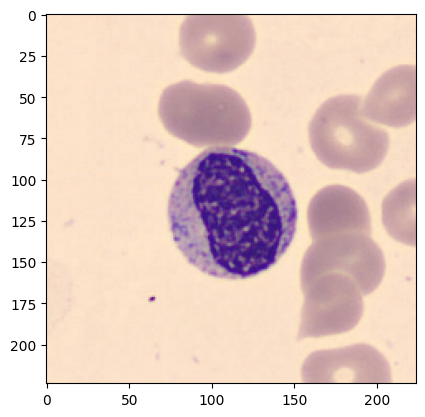

In [ ]:
for train_x_batch, train_y_batch in train_dataset:
    print('first image array', train_x_batch[0])
    plt.imshow(train_x_batch[0].numpy().astype("uint8"))
    print('first label', train_y_batch[0])
    break

**DATA AUGMENTATION**

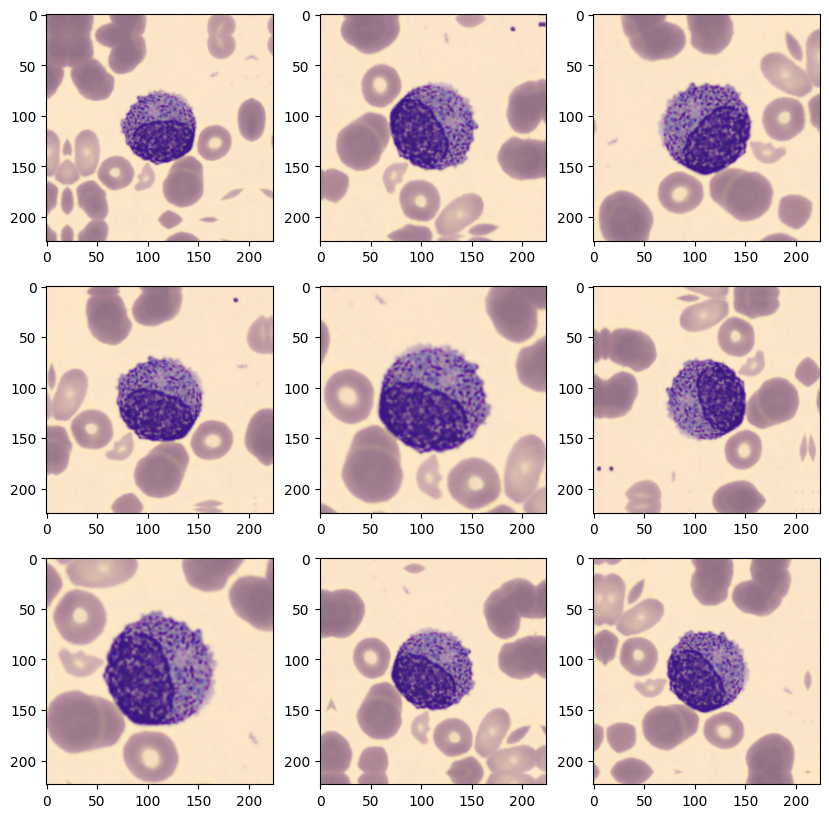

In [ ]:
def data_augmentation(x):
  x= layers.RandomFlip("horizontal")(x)
  x=layers.RandomRotation(0.25)(x)
  x = layers.RandomZoom(0.25)(x)
  return x
plt.figure(figsize=(10, 10))

# EXAMPLE SAMPLE IMAGE
#Get a batch of train_dataset
for image_batch, _ in train_dataset:
    #get the first image in the batch
    sample_image= image_batch[0]
    break;
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  augmented_image = data_augmentation(sample_image)
  plt.imshow(augmented_image.numpy().astype("uint8"))


# BASE LINE CNN WITH AUGMENTATION

-**Augmentation** for the images in only the training data during training to prevent data leakage

-**Rescaled** the values by dividing it with 255 as the pixel value is 255.

-Added **Dropout** of **0.25** for each block

-Added **Dense layer** with a **dropout** rate of **0.5** and **Batch Normalization** followed by a **softmax** function with output of **8** neurons for each respective target

-Used **Categorical CrossEntropy** for loss


In [ ]:
def build_baseline_with_aug(input_shape, filters):

    # input layer for getting the input image
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # Rescaling layer for rescaling pixels to [0,1] range
    x = layers.Rescaling(1./255)(x)

    for f in filters:
        # conv + batchnorm + relu for extracting features
        # MaxPooling layer added
        x = layers.Conv2D(filters=f, kernel_size=3, padding = "same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        x = layers.Conv2D(filters=f, kernel_size=3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        x = layers.MaxPooling2D(pool_size=2, padding="same")(x)

        # DROPOUT
        x = layers.Dropout(0.25)(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # DENSE LAYER
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.5)(x)
    output = layers.Dense(8, activation="softmax")(x)

    # create and return the model
    model = keras.Model(inputs=inputs, outputs=output)
    return model


baseline_with_aug = build_baseline_with_aug(
    input_shape=(224 , 224, 3),
    filters=[32, 64, 128, 256]
)
print(baseline_with_aug.summary())


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_76 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_76              │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_76 (RandomZoom)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_32 (ReLU)                 │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_33 (ReLU)                 │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_34 (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_35 (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,244,968 (4.75 MB)

 Trainable params: 1,242,536 (4.74 MB)

 Non-trainable params: 2,432 (9.50 KB)

None


**BASELINE CNN WITH AUGMENTATION**

The graphs show that the model works good for the initial epochs but then starts to **overfit** the model.


In [ ]:
# Compile with a smaller stable LR
opt = keras.optimizers.Adam(learning_rate=1e-4)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, min_delta=1e-4, restore_best_weights=True)

baseline_with_aug.compile( loss="categorical_crossentropy", metrics=['accuracy'],optimizer=opt)

# Train using fixed validation set
history = baseline_with_aug.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=early_stopping
)


Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - accuracy: 0.6936 - loss: 0.9012 - val_accuracy: 0.1374 - val_loss: 8.0139
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.8806 - loss: 0.3586 - val_accuracy: 0.2366 - val_loss: 3.8787
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9135 - loss: 0.2558 - val_accuracy: 0.6201 - val_loss: 1.1350
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9254 - loss: 0.2220 - val_accuracy: 0.6294 - val_loss: 1.3924
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9339 - loss: 0.2008 - val_accuracy: 0.7606 - val_loss: 0.7929
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9374 - loss: 0.1875 - val_accuracy: 0.6373 - val_loss: 1.5894
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9415 - loss: 0.1710 - val_accuracy: 0.8419 - val_loss: 0.4570
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9456 - loss: 0.1597 - 

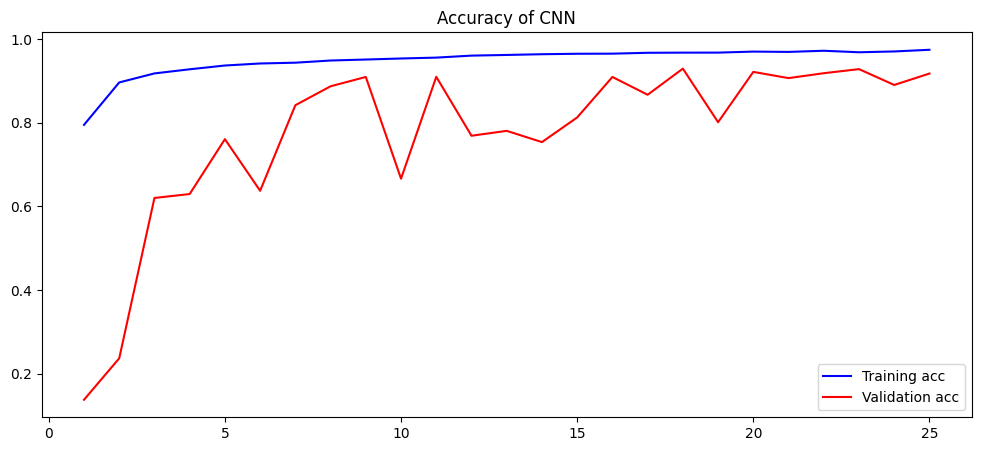

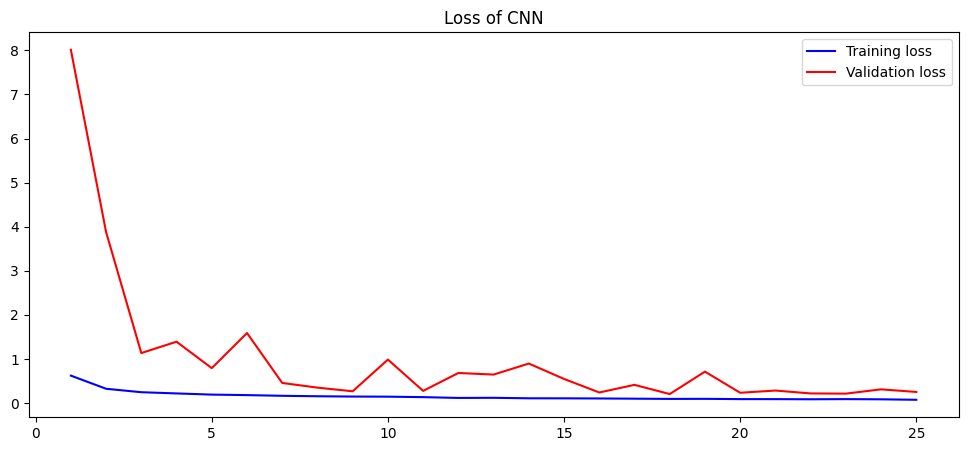

In [ ]:
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12,5))
plt.plot(epochs, history.history['accuracy'], 'b', label='Training acc')
plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation acc')
plt.title('Accuracy of CNN')

plt.legend()

plt.figure(figsize=(12,5))
plt.plot(epochs, history.history['loss'], 'b', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
plt.title('Loss of CNN')
plt.legend()
plt.show()


**Learning Rate Scheduler,  Checkpointing**

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.5)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
baseline_with_aug.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=opt)
#callback for early stopping. stop the training if the validation_loss does not improve after 7 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, restore_best_weights=True)
#save the checkpointed model in your google drive cnn_lab directory: "drive/MyDrive/cnn_lab/baseline_checkpoint" .
checkpoint= keras.callbacks.ModelCheckpoint( filepath="drive/MyDrive/baseline_checkpoint.keras",save_best_only=True, monitor="val_loss")
history = baseline_with_aug.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = 50,
            verbose = 1,
            callbacks=[early_stopping, checkpoint])

Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - accuracy: 0.8604 - loss: 0.4398 - val_accuracy: 0.4045 - val_loss: 3.8491
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9225 - loss: 0.2258 - val_accuracy: 0.7571 - val_loss: 0.8756
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9327 - loss: 0.1986 - val_accuracy: 0.9309 - val_loss: 0.1952
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9495 - loss: 0.1497 - val_accuracy: 0.9004 - val_loss: 0.2863
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9615 - loss: 0.1158 - val_accuracy: 0.7802 - val_loss: 0.8923
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9607 - loss: 0.1125 - val_accuracy: 0.9250 - val_loss: 0.2355
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9703 - loss: 0.0925 - val_accuracy: 0.9512 - val_loss: 0.1394
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.9757 - loss: 0.0763 - 

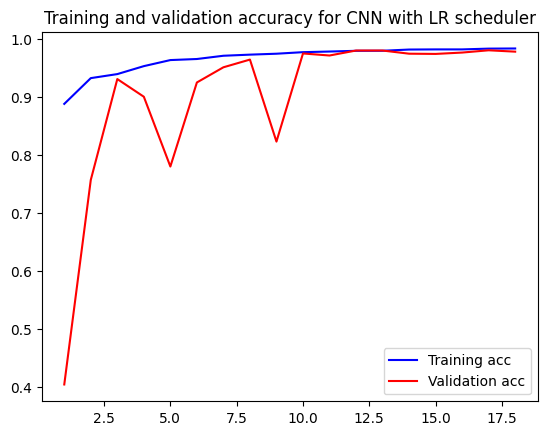

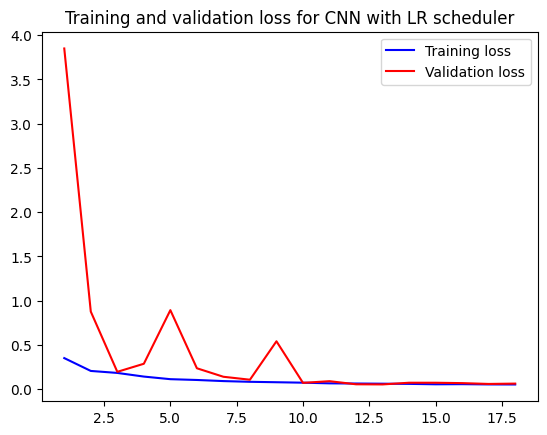

In [ ]:

#getting train and validation accuracies
train_acc_CNN = history.history['accuracy']
val_acc_CNN = history.history['val_accuracy']

#getting train and validation losses
train_loss_CNN = history.history['loss']
val_loss_CNN = history.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN with LR scheduler')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN with LR scheduler')
plt.legend()

plt.show()

Learning Rate Reduce on Plateau, checkpointing

In [ ]:
lr_plateau = keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
opt = tf.keras.optimizers.Adam()
baseline_with_aug.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=opt)
#callback for early stopping. stop the training if the validation_loss does not improve after 7 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, restore_best_weights=True)
#save the checkpointed model in your google drive cnn_lab directory: "drive/MyDrive/cnn_lab/baseline_checkpoint" .
checkpoint= keras.callbacks.ModelCheckpoint( filepath="drive/MyDrive/lr_plateau_checkpoint.keras",save_best_only=True, monitor="val_loss")
history = baseline_with_aug.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = 50,
            verbose = 1,
            callbacks=[early_stopping, lr_plateau, checkpoint])

Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 65ms/step - accuracy: 0.9362 - loss: 0.1983 - val_accuracy: 0.2433 - val_loss: 16.6848 - learning_rate: 0.0010
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9412 - loss: 0.1694 - val_accuracy: 0.1824 - val_loss: 92.8543 - learning_rate: 0.0010
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9480 - loss: 0.1580 - val_accuracy: 0.2132 - val_loss: 9.6834 - learning_rate: 0.0010
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9549 - loss: 0.1377 - val_accuracy: 0.2917 - val_loss: 5.7398 - learning_rate: 0.0010
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9580 - loss: 0.1219 - val_accuracy: 0.6728 - val_loss: 1.2698 - learning_rate: 0.0010
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9489 - loss: 0.1444 - val_accuracy: 0.2343 - val_loss: 11.4588 - learning_rate: 0.0010
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9576 

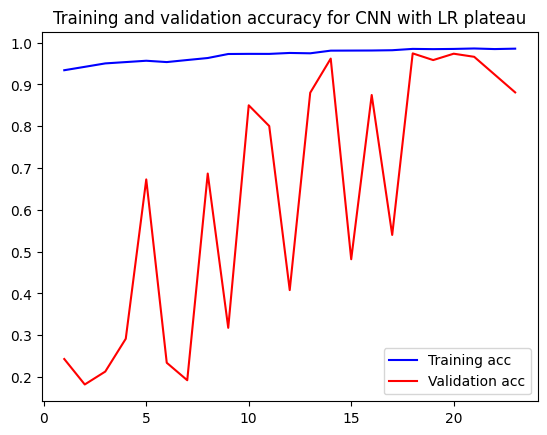

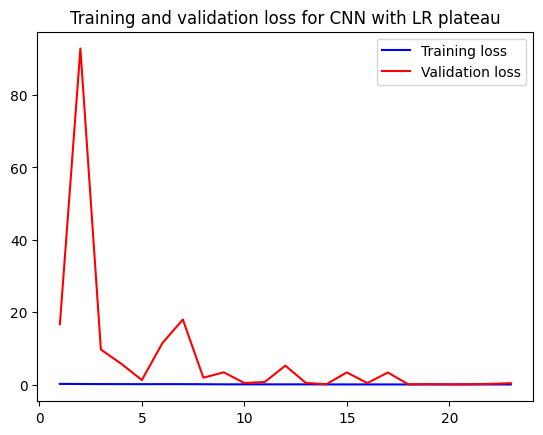

In [ ]:

#getting train and validation accuracies
train_acc_CNN = history.history['accuracy']
val_acc_CNN = history.history['val_accuracy']

#getting train and validation losses
train_loss_CNN = history.history['loss']
val_loss_CNN = history.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN with LR plateau')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN with LR plateau')
plt.legend()

plt.show()

# RESNET

-**ResNet50** is used to train the dataset.

- A pretrained **imagenet** is used for the initial weights.


In [ ]:
from tensorflow.keras.applications import ResNet50
conv_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
#freeze the weight of the convolutional base
conv_base.trainable=False
# get the summary of the model to view its architecture
conv_base.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

**TRAINING ON WEIGHTS OF RESNET50**

-Used only early stopping

-Observing the graphs we can say that

In [ ]:

def build_pretrained(input_shape):

  #input layer for getting the input image
  input = keras.Input(shape=input_shape)
  #Add the data_augmentation layers here:
  x=data_augmentation(input)
  #rescaling layer for rescalign pixels to [0,1] range
  x = layers.Rescaling(1./255)(x)
  #Using the pre-trained conv_base
  x = conv_base(x)
  #Global Average pooling. This will get an input of shape (height, width, channels) the average of each feature map and returns a vector of size channels.
  x = layers.GlobalAveragePooling2D()(x)
  #The final output layer has one neuron with sigmoid activation to output the probability of the target class ( cate or dog whichever is labled as one)
  output=layers.Dense(8, activation="softmax")(x)
  #create a model and set its input and output and return it
  model = keras.Model(inputs=input, outputs=output)
  return model
pretrained_model=build_pretrained(input_shape=(224,224,3))
print(pretrained_model.summary())



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_77 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_77              │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_77 (RandomZoom)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,604,104 (90.04 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


In [ ]:

#compiling the model
opt = tf.keras.optimizers.Adam()
pretrained_model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=opt)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, restore_best_weights=True)
history = pretrained_model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = 50,
            verbose = 1,
            callbacks=[early_stopping])

Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.2007 - loss: 2.0056 - val_accuracy: 0.1824 - val_loss: 1.9169
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.2982 - loss: 1.9033 - val_accuracy: 0.3448 - val_loss: 1.8062
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.3652 - loss: 1.8220 - val_accuracy: 0.4295 - val_loss: 1.7191
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.3988 - loss: 1.7587 - val_accuracy: 0.4881 - val_loss: 1.6425
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.4098 - loss: 1.7070 - val_accuracy: 0.3932 - val_loss: 1.6112
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.4184 - loss: 1.6694 - val_accuracy: 0.4772 - val_loss: 1.5507
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.4377 - loss: 1.6288 - val_accuracy: 0.4857 - val_loss: 1.5109
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.4472 - loss: 1.5848 - 

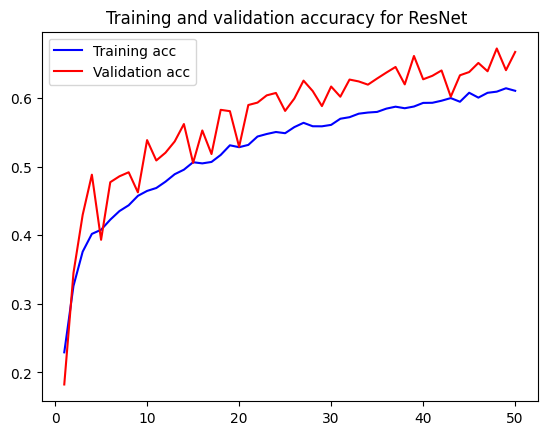

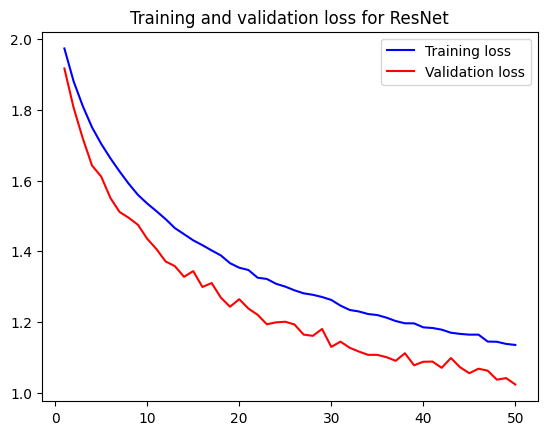

In [ ]:

#getting train and validation accuracies
train_acc_CNN = history.history['accuracy']
val_acc_CNN = history.history['val_accuracy']

#getting train and validation losses
train_loss_CNN = history.history['loss']
val_loss_CNN = history.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r', label='Validation acc')
plt.title('Training and validation accuracy for ResNet ')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN, 'r', label='Validation loss')
plt.title('Training and validation loss for ResNet')
plt.legend()

plt.show()

**FINE TUNING ON THE RESNET50**

In [ ]:

#unfreez the convolution base
conv_base.trainable = True

#set trainable to False for all layers except the last 9 , that is freeze the weights for all layers except the last 9 layers
for layer in conv_base.layers[:-9]:
    layer.trainable=False

#set trainable to True for the convolutional layhers in the last 9 layers.
for layer in conv_base.layers[-9:]:
    # we only want to unfreez the convolutional layers (batch normalizataion layers remain frozen)
    if layer.name.endswith("conv"):
      layer.trainable=True

print(pretrained_model.summary())


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_77 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_77              │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_77 (RandomZoom)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,636,890 (90.17 MB)

 Trainable params: 3,432,968 (13.10 MB)

 Non-trainable params: 20,171,136 (76.95 MB)

 Optimizer params: 32,786 (128.07 KB)

None


In [ ]:

#compiling the model
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
pretrained_model.compile(loss="binary_crossentropy", metrics=['accuracy'], optimizer=opt)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, restore_best_weights=True)

history = pretrained_model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = 50,
            verbose = 1,
            callbacks=[early_stopping])


Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.5076 - loss: 0.7871 - val_accuracy: 0.3417 - val_loss: 0.7623
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.6585 - loss: 0.2070 - val_accuracy: 0.7071 - val_loss: 0.1908
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.6848 - loss: 0.1933 - val_accuracy: 0.7114 - val_loss: 0.1812
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.6992 - loss: 0.1863 - val_accuracy: 0.7224 - val_loss: 0.1799
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.7100 - loss: 0.1794 - val_accuracy: 0.6978 - val_loss: 0.1896
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.7136 - loss: 0.1758 - val_accuracy: 0.7247 - val_loss: 0.1861
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.7267 - loss: 0.1704 - val_accuracy: 0.7403 - val_loss: 0.1617
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.7309 - loss: 0.1682 - 

In [ ]:
#savng the modle on disk
pretrained_model.save("drive/MyDrive/resnetfinetuned.h5")

In [ ]:
test_dir = os.path.join(base_dir, 'test')

#compute the loss and accurracy on the test set using model.evaluate method
test_loss, test_acc = pretrained_model.evaluate(test_dataset)
print('test acc:', test_acc)

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7984 - loss: 0.1435
test acc: 0.8094868063926697


# VISION TRANSFORMER

-Using vit_base_patch16_224_imagenet21k as a base for the weights


In [ ]:
# !pip install keras_cv # Install keras_cv

In [ ]:


IMAGE_SIZE_INPUT = 224   # your dataset image size
VIT_IMAGE_SIZE   = 224   # ViT pretrained resolution
NUM_CLASSES = 8

In [ ]:
conv_base_vit = keras_nlp.models.ViTBackbone.from_preset(
    "vit_base_patch16_224_imagenet21k",
)

# Freeze initially (feature extractor phase)
conv_base_vit.trainable = False
conv_base_vit.summary()

Model: "vi_t_backbone"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vit_patching_and_embedding      │ (None, 197, 768)       │       742,656 │
│ (ViTPatchingAndEmbedding)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vit_encoder (ViTEncoder)        │ (None, 197, 768)       │    85,056,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,798,656 (327.30 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 85,798,656 (327.30 MB)

In [ ]:
def build_pretrained(input_shape=(IMAGE_SIZE_INPUT, IMAGE_SIZE_INPUT, 3)):

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)

    # Resize to ViT expected size (224x224)
    x = layers.Resizing(VIT_IMAGE_SIZE, VIT_IMAGE_SIZE)(x)

    #   Pass through pretrained ViT backbone
    #    Output: (batch, num_tokens, hidden_dim)
    x = conv_base_vit(x, training=False)

    #  Global average over tokens
    x = layers.GlobalAveragePooling1D()(x)

    #  Final classifier for your 8 classes
    outputs = layers.Dense(8, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="vit_transfer")
    return model

pretrained_model = build_pretrained(input_shape=(224, 224, 3))
print(pretrained_model.summary())

# pretrained_model = build_pretrained()
# print(pretrained_model.summary())


Model: "vit_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_78 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_78              │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_78 (RandomZoom)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_backbone (ViTBackbone)     │ (None, 197, 768)       │    85,798,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │         6,152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,804,808 (327.32 MB)

 Trainable params: 6,152 (24.03 KB)

 Non-trainable params: 85,798,656 (327.30 MB)

None


**TRAINING PHASE**

In [ ]:

opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

pretrained_model.compile(loss="categorical_crossentropy",metrics=["accuracy"],optimizer=opt,)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)

history = pretrained_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping],
)


Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 35s 65ms/step - accuracy: 0.3200 - loss: 1.9206 - val_accuracy: 0.5584 - val_loss: 1.5758
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.5757 - loss: 1.5298 - val_accuracy: 0.6216 - val_loss: 1.3314
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.6294 - loss: 1.3222 - val_accuracy: 0.6576 - val_loss: 1.1808
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.6664 - loss: 1.1824 - val_accuracy: 0.6857 - val_loss: 1.0750
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.6895 - loss: 1.0906 - val_accuracy: 0.7111 - val_loss: 0.9940
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.7126 - loss: 1.0133 - val_accuracy: 0.7317 - val_loss: 0.9302
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.7241 - loss: 0.9549 - val_accuracy: 0.7505 - val_loss: 0.8763
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.7433 - loss: 0.9053 - 

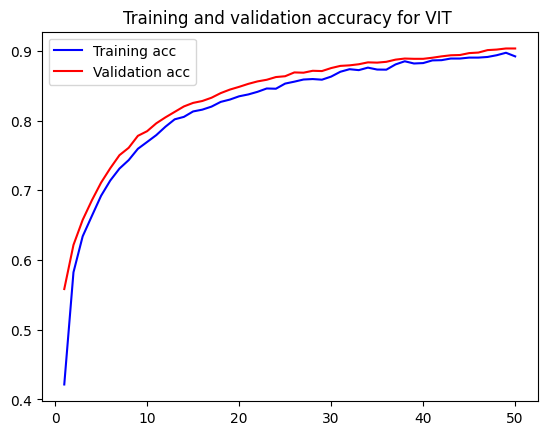

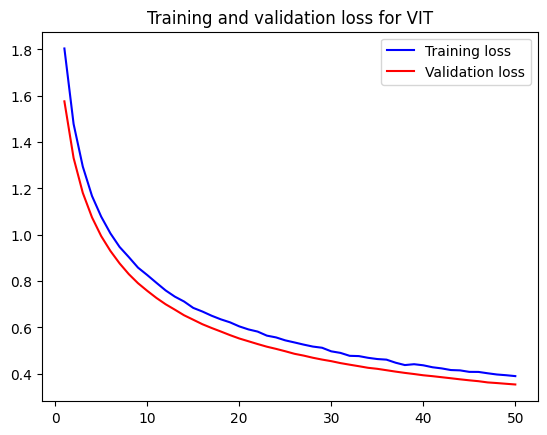

In [ ]:

#getting train and validation accuracies
train_acc_VIT = history.history['accuracy']
val_acc_VIT = history.history['val_accuracy']

#getting train and validation losses
train_loss_VIT = history.history['loss']
val_loss_VIT = history.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_VIT, 'b', label='Training acc')
plt.plot(epochs, val_acc_VIT, 'r', label='Validation acc')
plt.title('Training and validation accuracy for VIT ')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_VIT, 'b', label='Training loss')
plt.plot(epochs, val_loss_VIT, 'r', label='Validation loss')
plt.title('Training and validation loss for VIT')
plt.legend()

plt.show()

**FINE TUNING PHASE**

In [ ]:
conv_base_vit.trainable = True  # unfreeze ViT

# Optionally: freeze most layers and only fine-tune the top part
for layer in conv_base_vit.layers[:-4]:
    layer.trainable = False

print(pretrained_model.summary())

opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
pretrained_model.compile(
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=opt,
)

history = pretrained_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping],
)


Model: "vit_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_78 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_78              │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_78 (RandomZoom)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_backbone (ViTBackbone)     │ (None, 197, 768)       │    85,798,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │         6,152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,817,114 (327.37 MB)

 Trainable params: 85,804,808 (327.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,306 (48.07 KB)

None
Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 98s 182ms/step - accuracy: 0.9365 - loss: 0.1897 - val_accuracy: 0.9750 - val_loss: 0.0775
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 66s 176ms/step - accuracy: 0.9737 - loss: 0.0768 - val_accuracy: 0.9762 - val_loss: 0.0654
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 66s 177ms/step - accuracy: 0.9818 - loss: 0.0501 - val_accuracy: 0.9820 - val_loss: 0.0523
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 66s 176ms/step - accuracy: 0.9849 - loss: 0.0425 - val_accuracy: 0.9824 - val_loss: 0.0506
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 66s 176ms/step - accuracy: 0.9876 - loss: 0.0386 - val_accuracy: 0.9852 - val_loss: 0.0464
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - accuracy: 0.9902 - loss: 0.0281 - val_accuracy: 0.9824 - val_loss: 0.0549
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 66s 176ms/step - accuracy: 0.9900 - loss: 0.0251 - val_accuracy: 0.9824 - val_loss: 0.0530
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 66s 176ms/step - accuracy: 0.9919 - lo

In [ ]:
#savng the modle on disk
pretrained_model.save("drive/MyDrive/vitfinetuned.h5")

In [ ]:
test_dir = os.path.join(base_dir, 'test')

#compute the loss and accurracy on the test set using model.evaluate method
test_loss, test_acc = pretrained_model.evaluate(test_dataset)
print('test acc:', test_acc)

81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9914 - loss: 0.0289
test acc: 0.9875583052635193


Showing misclassified images:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
True label is: erythroblast, Predicted: ig with confidence 0.9668


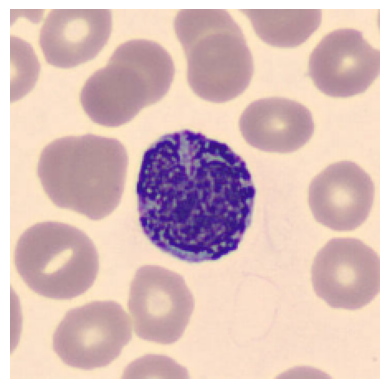

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
True label is: platelet, Predicted: ig with confidence 0.5320


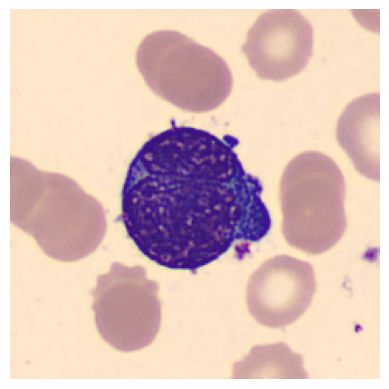

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
True label is: ig, Predicted: erythroblast with confidence 0.7743


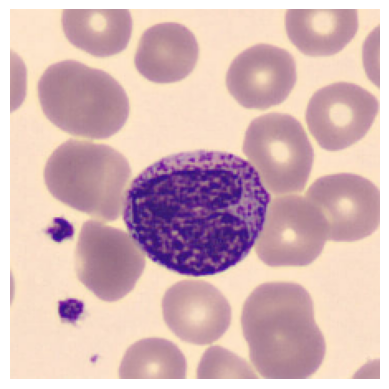

True label is: ig, Predicted: lymphocyte with confidence 0.9893


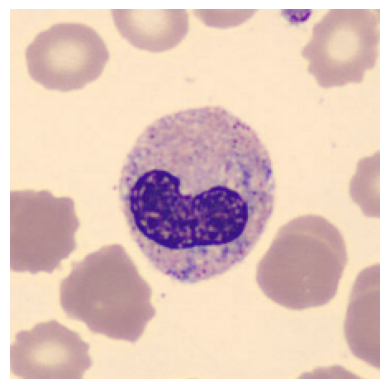

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
True label is: ig, Predicted: lymphocyte with confidence 0.5290


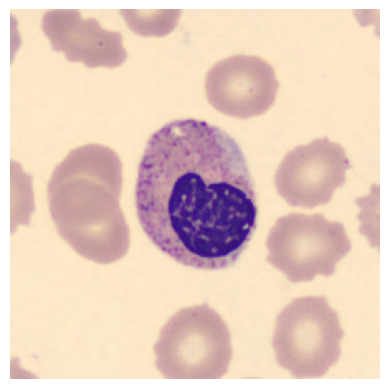

True label is: ig, Predicted: lymphocyte with confidence 0.9839


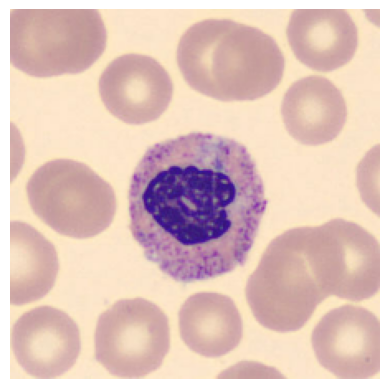

True label is: ig, Predicted: lymphocyte with confidence 0.5017


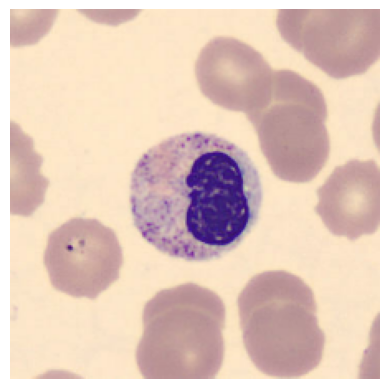

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
True label is: ig, Predicted: lymphocyte with confidence 0.9957


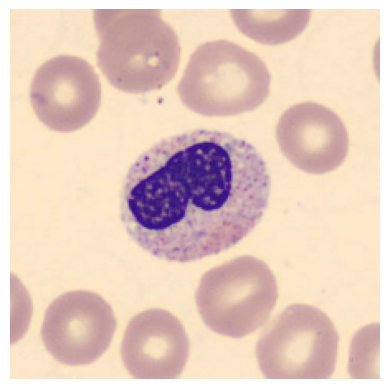

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
True label is: ig, Predicted: lymphocyte with confidence 0.9737


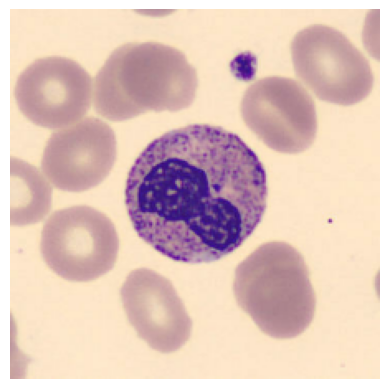

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
True label is: ig, Predicted: lymphocyte with confidence 0.7815


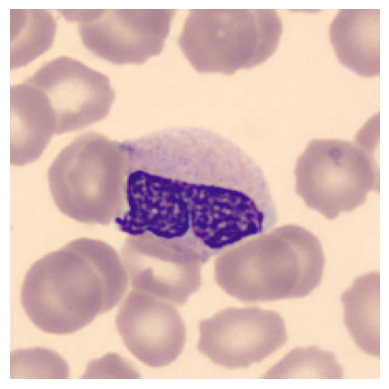

True label is: ig, Predicted: platelet with confidence 0.7631


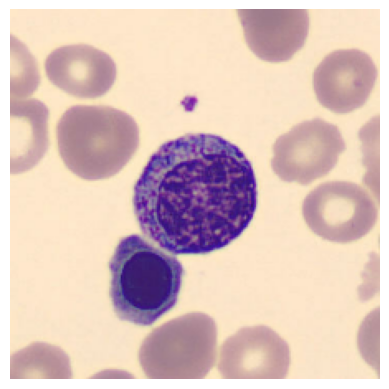

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
True label is: ig, Predicted: platelet with confidence 0.7010


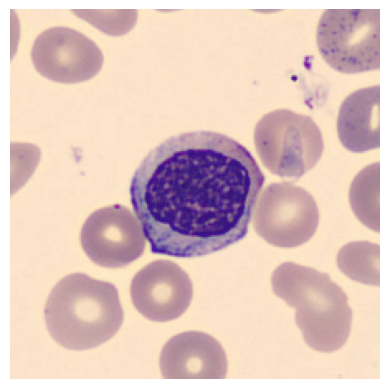

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
True label is: ig, Predicted: platelet with confidence 0.9950


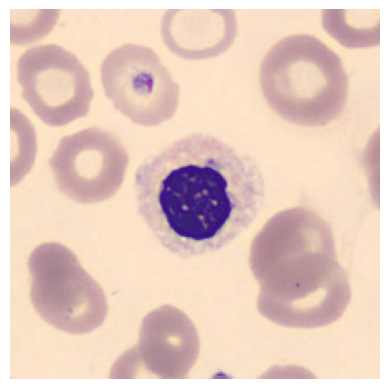

True label is: ig, Predicted: erythroblast with confidence 0.8679


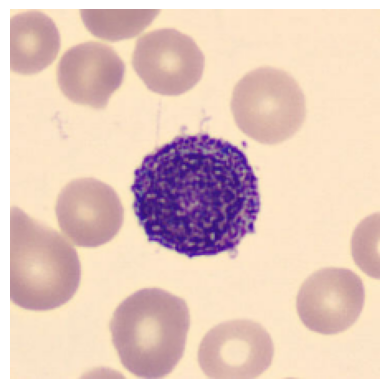

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
True label is: ig, Predicted: erythroblast with confidence 0.6270


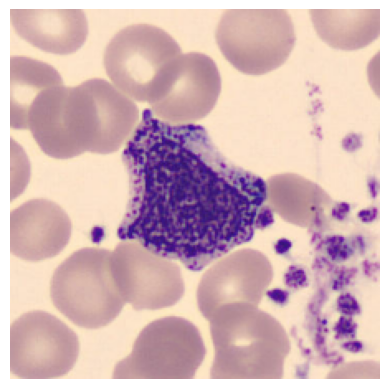

True label is: ig, Predicted: lymphocyte with confidence 0.8721


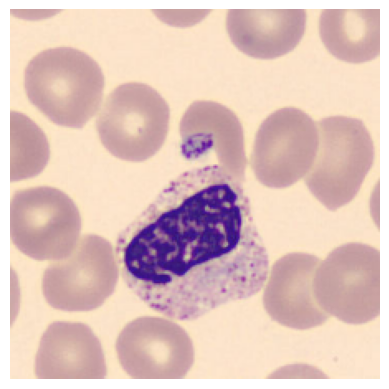

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
True label is: eosinophil, Predicted: monocyte with confidence 0.8772


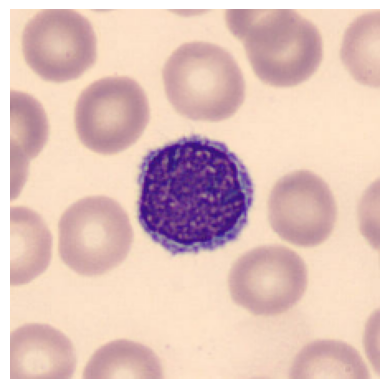

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
True label is: eosinophil, Predicted: monocyte with confidence 0.6876


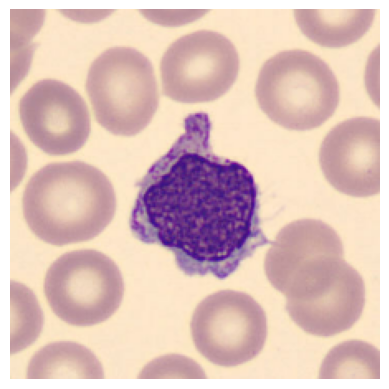

True label is: monocyte, Predicted: ig with confidence 0.7230


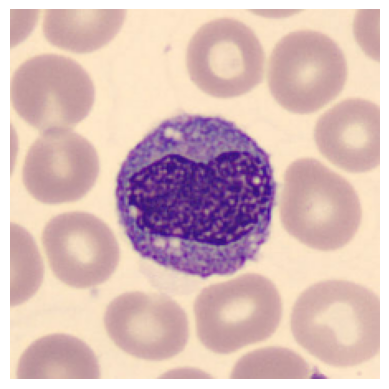

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
True label is: monocyte, Predicted: ig with confidence 0.9810


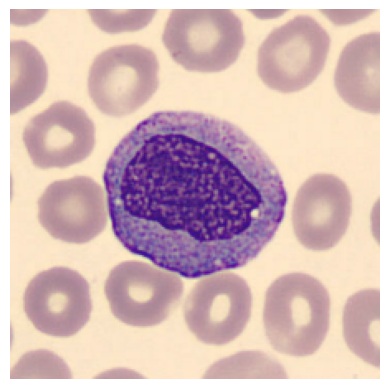

True label is: monocyte, Predicted: ig with confidence 0.6201


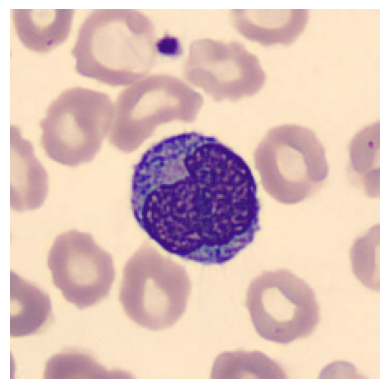

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
True label is: monocyte, Predicted: ig with confidence 0.7449


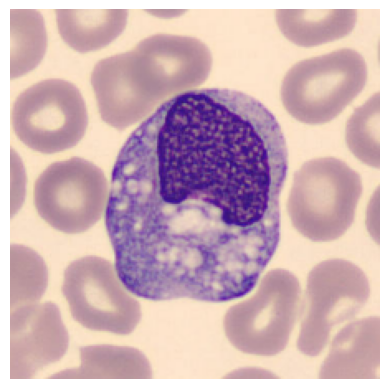

True label is: monocyte, Predicted: eosinophil with confidence 0.6628


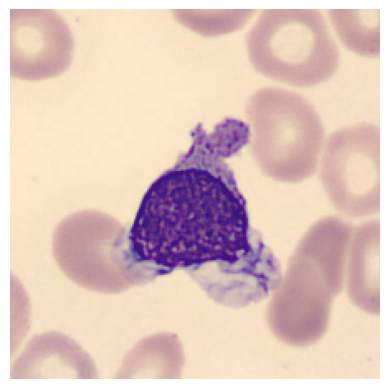

True label is: monocyte, Predicted: ig with confidence 0.9191


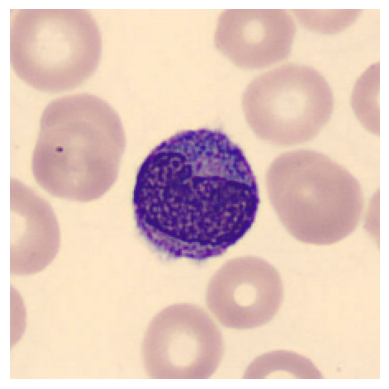

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
True label is: monocyte, Predicted: ig with confidence 0.8955


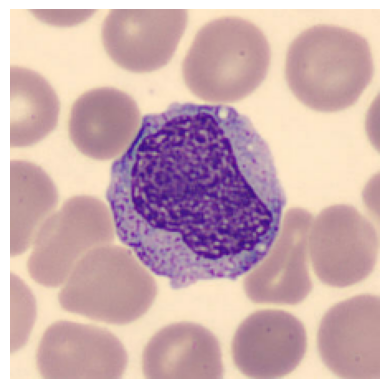

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
True label is: monocyte, Predicted: ig with confidence 0.6736


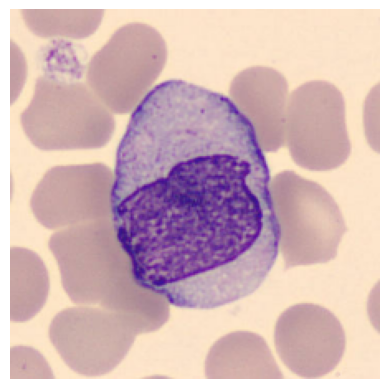

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
True label is: lymphocyte, Predicted: ig with confidence 0.9542


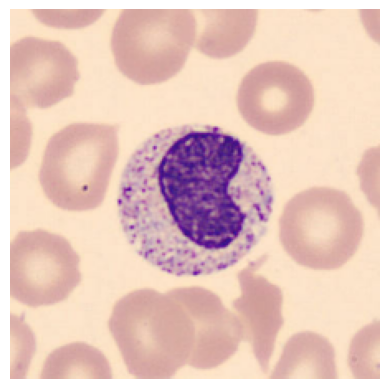

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
True label is: lymphocyte, Predicted: erythroblast with confidence 0.9963


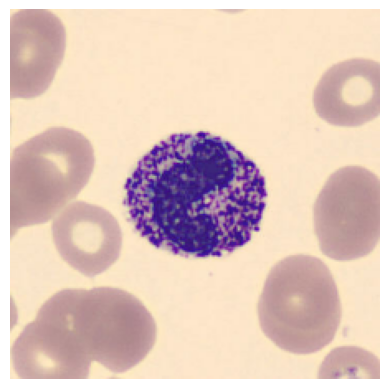

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
True label is: lymphocyte, Predicted: ig with confidence 0.6700


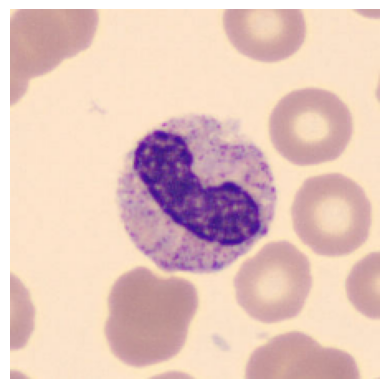

True label is: lymphocyte, Predicted: ig with confidence 0.8385


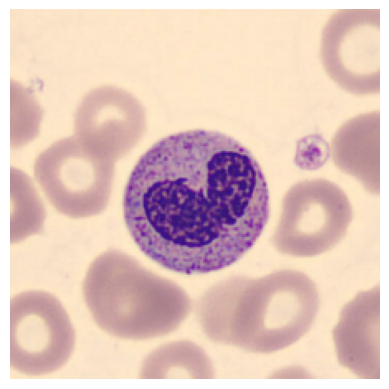

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
True label is: lymphocyte, Predicted: ig with confidence 0.7055


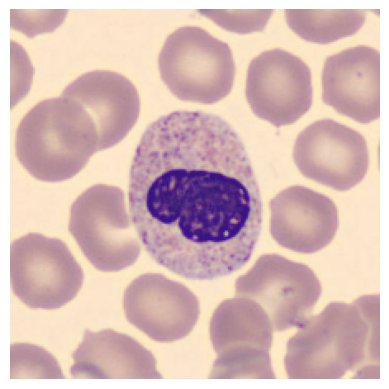

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
True label is: lymphocyte, Predicted: ig with confidence 0.6546


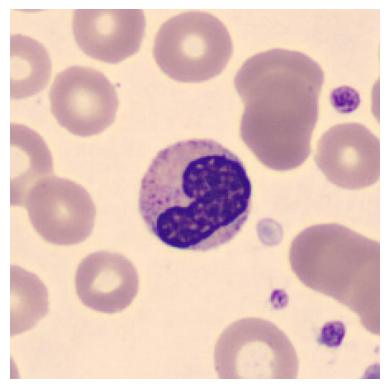

True label is: lymphocyte, Predicted: ig with confidence 0.9665


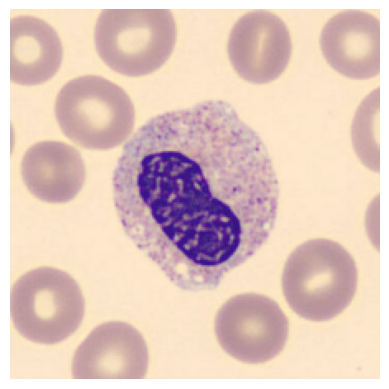

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
True label is: lymphocyte, Predicted: ig with confidence 0.5942


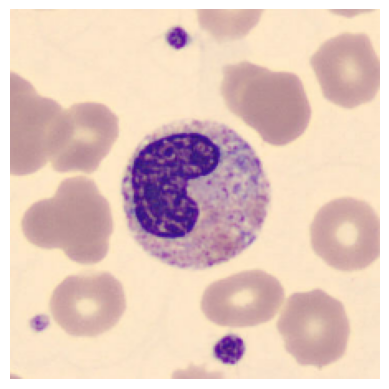

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
True label is: lymphocyte, Predicted: ig with confidence 0.9436


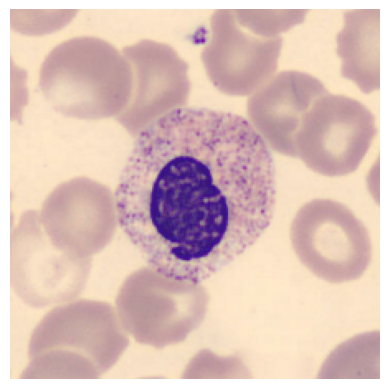

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Finished checking for misclassified images.


In [ ]:

batch_size=32
validation_size=2561 # Based on output of GCDqZktH0r6h: Found 2561 files belonging to 8 classes.
batch_index=0

print("Showing misclassified images:")

#Get each batch of images and labels in validation dataset
for image_batch, label_batch in validation_dataset:
    # Limit the number of batches processed to avoid excessive output if validation_size is large
    # and to ensure the loop terminates within reasonable time for demonstration.
    if batch_index >= math.ceil(validation_size / batch_size):
        break;

    # Get the predicted probabilities for the images in the batch. Shape: (batch_size, num_classes)
    y_pred_probabilities = pretrained_model.predict(image_batch)

    # Get the predicted class index for each image (argmax for multiclass)
    y_pred_classes = np.argmax(y_pred_probabilities, axis=1) # Shape: (batch_size,)

    # Get the true class index for each image (argmax for one-hot encoded labels)
    true_classes = np.argmax(label_batch.numpy(), axis=1) # Shape: (batch_size,)

    # Get the indices of the misclassified images in the batch
    errors = np.where(y_pred_classes != true_classes)[0]

    # Display the misclassified images together with their predicted and true labels
    for i in errors:
        true_label_name = classes[true_classes[i]]
        predicted_label_name = classes[y_pred_classes[i]]
        confidence = y_pred_probabilities[i, y_pred_classes[i]] # Confidence of the predicted class

        print(f"True label is: {true_label_name}, Predicted: {predicted_label_name} with confidence {confidence:.4f}")
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis('off') # Hide axes for cleaner image display
        plt.show()

    batch_index += 1

print("\nFinished checking for misclassified images.")


## Conclusion
This project demonstrates the effectiveness of CNN-based architectures for medical image classification. While the baseline CNN achieved strong accuracy, pretrained models like ResNet50 provided better generalization when fine-tuned. Future work includes experimenting with Vision Transformers and explainability techniques.
